In [256]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import random
import simulation_utils
import range_construction
import importlib

from treys import Evaluator, Card, Deck

importlib.reload(simulation_utils)
importlib.reload(range_construction)

<module 'range_construction' from 'c:\\Users\\kuna8\\personal_projects\\poker_analysis\\src\\range_construction.py'>

$\textbf{Motivation}$: Throughout the tournament we've seen a consistent covergence to 3-4 handed play with an average stack depth of 15BB (with SD of ~5BB) no matter the lead held until this point. We've also been in the position of "big stack" at this convergence point, but more frequently than not,  have not won the table. Either our short-stack play is poor or the small sample size and variance has limited our EV realization. 

Given that we MUST secure 1st place finishes next match, I propose a strategy to eliminate unnecessary variance and secure at least a 2nd place finish. The goal is to reach heads-up play with at least an equal amount of chips compared to the opponent. 

$\textbf{Strategy}:$ When facing a shove from opponents, call with an extremely tight range: [AKs, partial AKo, KK, AA]. Our opponents are mainly shoving with [Pairs,A-high,K-high+] and even if they are shoving with worse, there is little reason to risk our chance of winning based on a 60-40 advantage. Thus, our calling range will typically dominate the opponent leading to a range versus range equity of 0.74. 

We will still continue against reasonably sized opens at a normal (attempting GTO) strategy. We will also be shoving ourselves from all positions when action is folded/limped to us. The rationale here is that we are only taking a terminal action (shoving/calling shoves) when we have an incentive to take down the dead money.

$\textbf{Questions to answer}:$ Do we get to heads-up with this strategy? What is the ratio between our stack and the opponents when heads up? What is smallest lead we can have where this strategy gives us a reasonable amount of chips while heads up?

$\textbf{Assumptions}:$ All spots will be shoves for sake of demonstration of the strategy. 

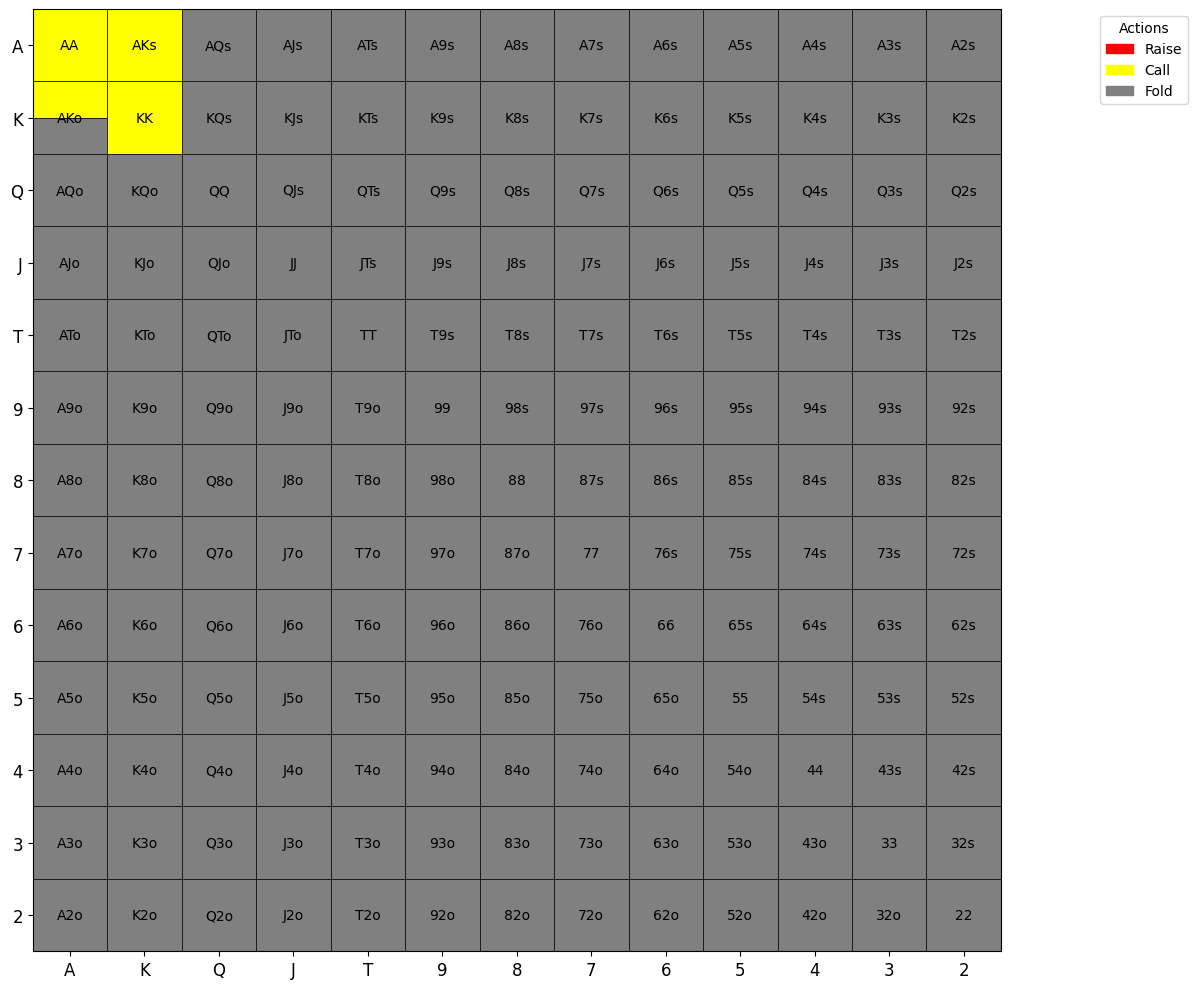

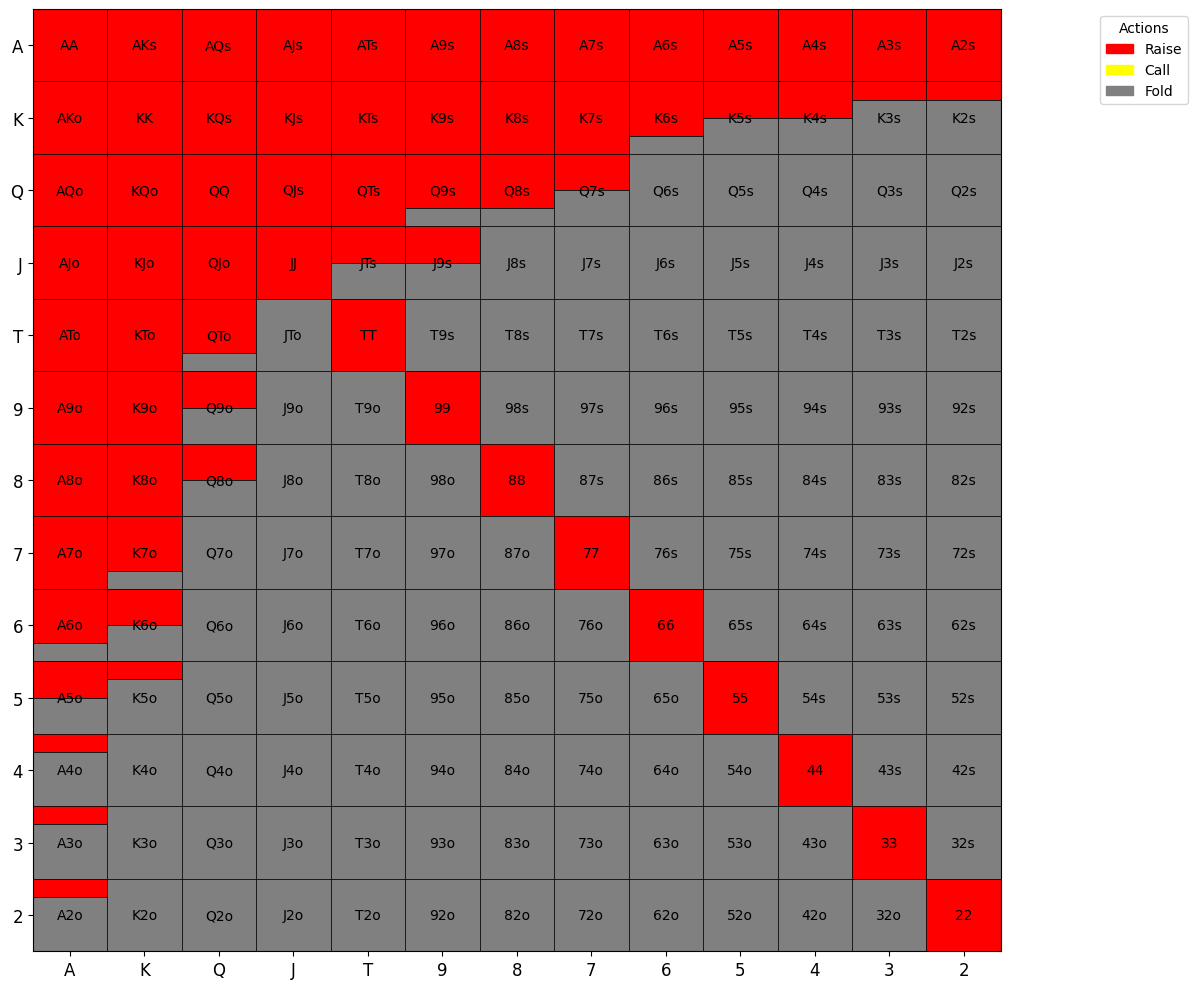

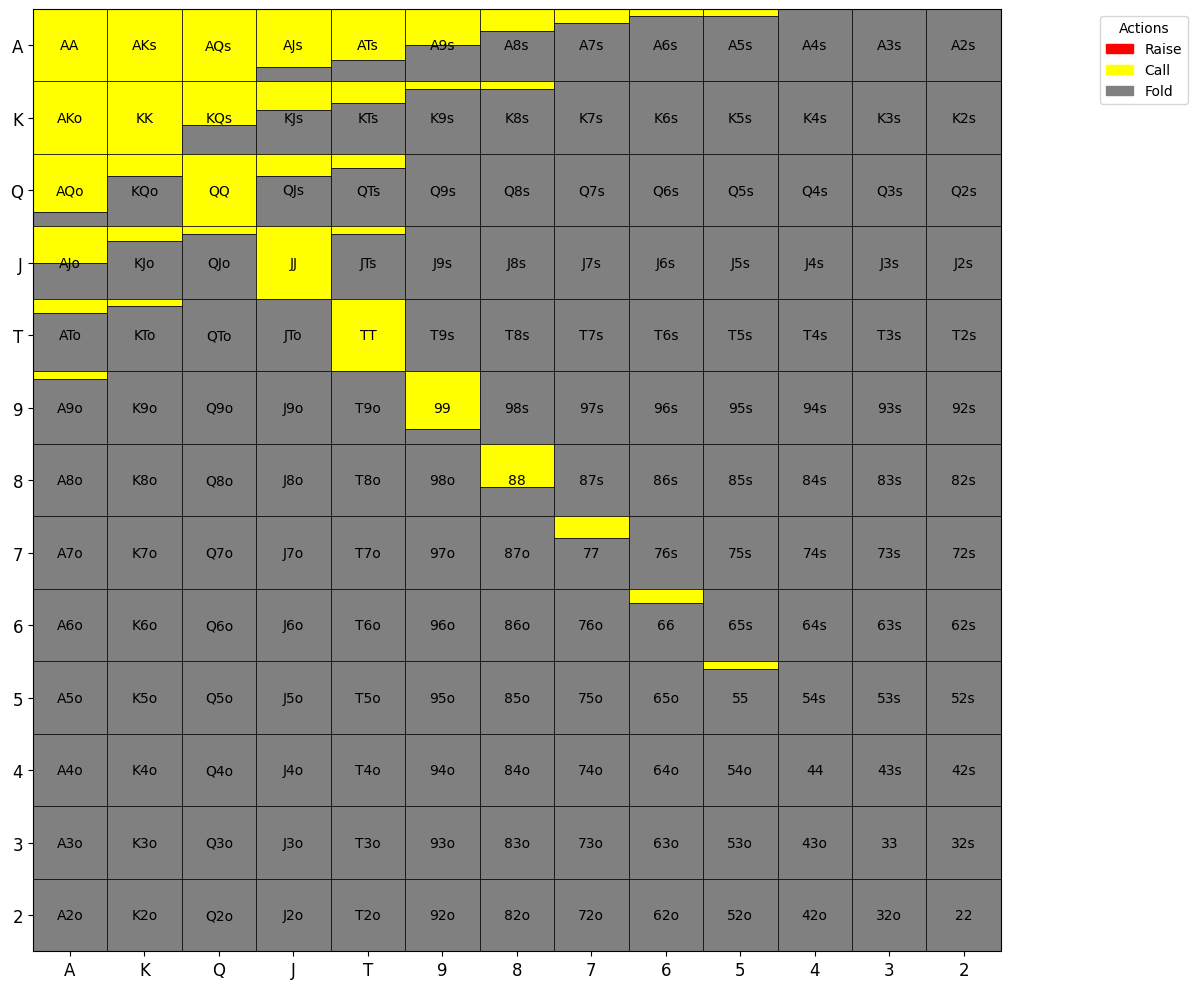

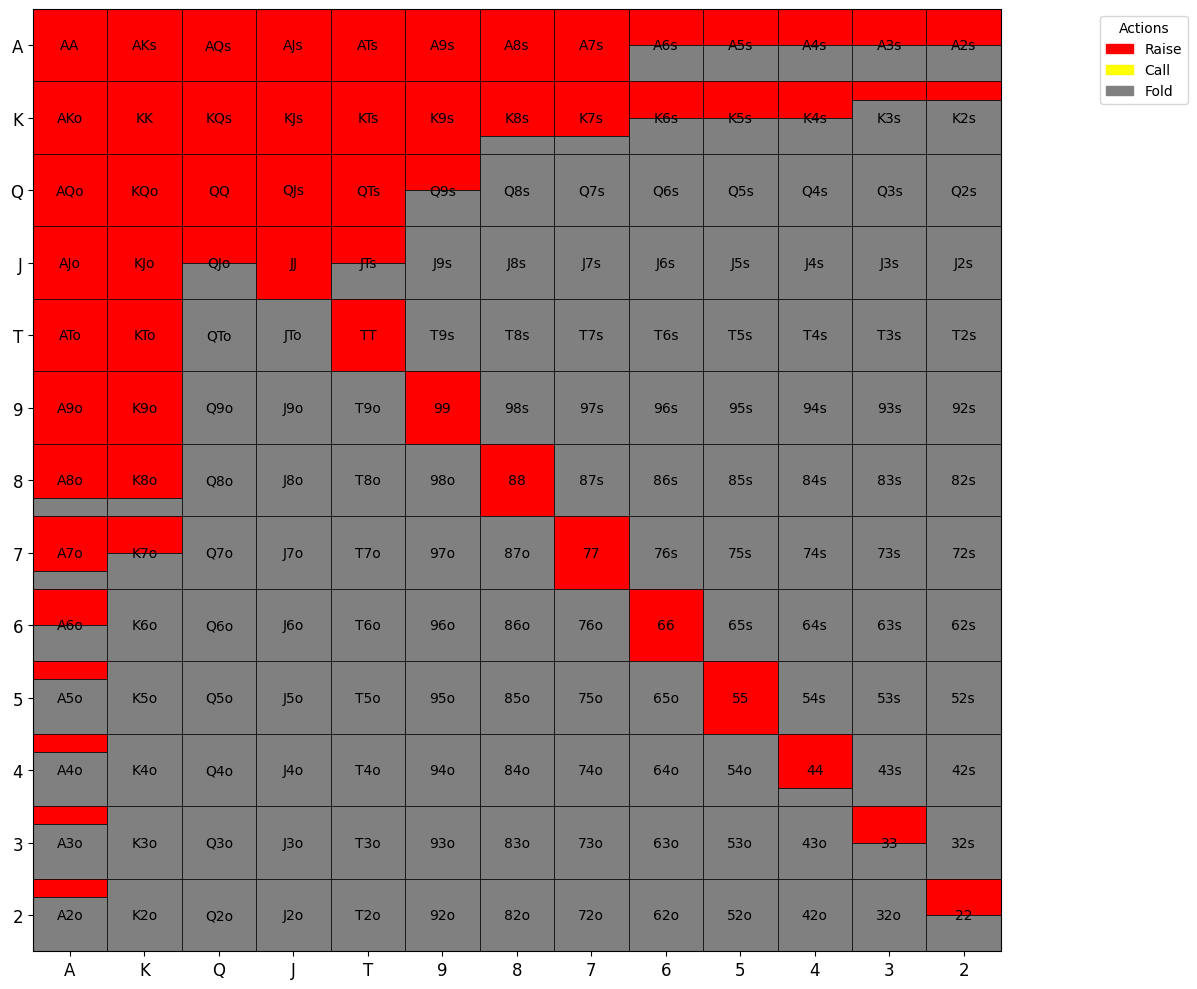

In [73]:
# Strategies
hero_calling_range = {
    # Pairs
    "AA": {"raise": 0.0, "call": 1.0},
    "KK": {"raise": 0.0, "call": 1.0},
    "AKo": {"raise": 0.0, "call": 0.5},
    "AKs": {"raise": 0.0, "call": 1.0},
} 

hero_shove_range = {
    # Pairs
    "AA": {"raise": 1.0, "call": 0.0},
    "KK": {"raise": 1.0, "call": 0.0},
    "QQ": {"raise": 1.0, "call": 0.0},
    "JJ": {"raise": 1.0, "call": 0.0},
    "TT": {"raise": 1.0, "call": 0.0},
    "99": {"raise": 1.0, "call": 0.0},
    "77": {"raise": 1.0, "call": 0.0},
    "88": {"raise": 1.0, "call": 0.0},
    "66": {"raise": 1.0, "call": 0.0},
    "55": {"raise": 1.0, "call": 0.0},
    "44": {"raise": 1.0, "call": 0.0},
    "33": {"raise": 1.0, "call": 0.0},
    "22": {"raise": 1.0, "call": 0.0},

    "AKs": {"raise": 1.0, "call": 0.0},
    "AQs": {"raise": 1.0, "call": 0.0},
    "AJs": {"raise": 1.0, "call": 0.0},
    "ATs": {"raise": 1.0, "call": 0.0},
    "A9s": {"raise": 1.0, "call": 0.0},
    "A8s": {"raise": 1.0, "call": 0.0},
    "A7s": {"raise": 1.0, "call": 0.0},
    "A6s": {"raise": 1.0, "call": 0.0}, 
    "A5s": {"raise": 1.0, "call": 0.0},
    "A4s": {"raise": 1.0, "call": 0.0},
    "A3s": {"raise": 1.0, "call": 0.0},
    "A2s": {"raise": 1.0, "call": 0.0},

    "AKo": {"raise": 1.0, "call": 0.0},
    "AQo": {"raise": 1.0, "call": 0.0},
    "AJo": {"raise": 1.0, "call": 0.0},
    "ATo": {"raise": 1.0, "call": 0.0}, 
    "A9o": {"raise": 1.0, "call": 0.0},
    "A8o": {"raise": 1.0, "call": 0.0}, 
    "A7o": {"raise": 1.0, "call": 0.0}, 
    "A6o": {"raise": 0.75, "call": 0.0},
    "A5o": {"raise": 0.5, "call": 0.0},
    "A4o": {"raise": 0.25, "call": 0.0},
    "A3o": {"raise": 0.25, "call": 0.0},
    "A2o": {"raise": 0.25, "call": 0.0},

    "KQs": {"raise": 1.0, "call": 0.0},
    "KJs": {"raise": 1.0, "call": 0.0},
    "KTs": {"raise": 1.0, "call": 0.0},
    "K9s": {"raise": 1.0, "call": 0.0},
    "K8s": {"raise": 1.0, "call": 0.0},
    "K7s": {"raise": 1.0, "call": 0.0},
    "K6s": {"raise": 0.75, "call": 0.0},
    "K5s": {"raise": 0.5, "call": 0.0},
    "K4s": {"raise": 0.5, "call": 0.0},
    "K3s": {"raise": 0.25, "call": 0.0},
    "K2s": {"raise": 0.25, "call": 0.0},

    "KQo": {"raise": 1.0, "call": 0.0},
    "KJo": {"raise": 1.0, "call": 0.0}, 
    "KTo": {"raise": 1.0, "call": 0.0},
    "K9o": {"raise": 1.0, "call": 0.0},
    "K8o": {"raise": 1.0, "call": 0.0},
    "K7o": {"raise": 0.75, "call": 0.0},    
    "K6o": {"raise": 0.5, "call": 0.0},    
    "K5o": {"raise": 0.25, "call": 0.0},    

    "QJs": {"raise": 1.0, "call": 0.0},
    "QTs": {"raise": 1.0, "call": 0.0},
    "Q9s": {"raise": 0.75, "call": 0.0},
    "Q8s": {"raise": 0.75, "call": 0.0},
    "Q7s": {"raise": 0.5, "call": 0.0},

    "QJo": {"raise": 1.0, "call": 0.0},
    "QTo": {"raise": 0.75, "call": 0.0},
    "Q9o": {"raise": 0.5, "call": 0.0},
    "Q8o": {"raise": 0.5, "call": 0.0},

    "JTs": {"raise": 0.5, "call": 0.0},
    "J9s": {"raise": 0.5, "call": 0.0},
}

villain_calling_range = {
    #----------------------------------
    # PAIRS
    #----------------------------------
    "AA": {"raise": 0.0, "call": 1.0},
    "KK": {"raise": 0.0, "call": 1.0},
    "QQ": {"raise": 0.0, "call": 1.0},
    "JJ": {"raise": 0.0, "call": 1.0},
    "TT": {"raise": 0.0, "call": 1.0},
    "99": {"raise": 0.0, "call": 0.8},
    "88": {"raise": 0.0, "call": 0.6},
    "77": {"raise": 0.0, "call": 0.3},
    "66": {"raise": 0.0, "call": 0.2},
    "55": {"raise": 0.0, "call": 0.1},
    "44": {"raise": 0.0, "call": 0.0},
    "33": {"raise": 0.0, "call": 0.0},
    "22": {"raise": 0.0, "call": 0.0},

    #----------------------------------
    # SUITED ACES
    #----------------------------------
    "AKs": {"raise": 0.0, "call": 1.0},
    "AQs": {"raise": 0.0, "call": 1.0},
    "AJs": {"raise": 0.0, "call": 0.8},
    "ATs": {"raise": 0.0, "call": 0.7},
    "A9s": {"raise": 0.0, "call": 0.5},
    "A8s": {"raise": 0.0, "call": 0.3},
    "A7s": {"raise": 0.0, "call": 0.2},
    "A6s": {"raise": 0.0, "call": 0.1},
    "A5s": {"raise": 0.0, "call": 0.1},
    "A4s": {"raise": 0.0, "call": 0.0},
    "A3s": {"raise": 0.0, "call": 0.0},
    "A2s": {"raise": 0.0, "call": 0.0},

    #----------------------------------
    # OFFSUIT ACES
    #----------------------------------
    "AKo": {"raise": 0.0, "call": 1.0},
    "AQo": {"raise": 0.0, "call": 0.8},
    "AJo": {"raise": 0.0, "call": 0.5},
    "ATo": {"raise": 0.0, "call": 0.2},
    "A9o": {"raise": 0.0, "call": 0.1},
    "A8o": {"raise": 0.0, "call": 0.0},
    "A7o": {"raise": 0.0, "call": 0.0},
    "A6o": {"raise": 0.0, "call": 0.0},
    "A5o": {"raise": 0.0, "call": 0.0},
    "A4o": {"raise": 0.0, "call": 0.0},
    "A3o": {"raise": 0.0, "call": 0.0},
    "A2o": {"raise": 0.0, "call": 0.0},

    #----------------------------------
    # SUITED KINGS
    #----------------------------------
    "KQs": {"raise": 0.0, "call": 0.6},
    "KJs": {"raise": 0.0, "call": 0.4},
    "KTs": {"raise": 0.0, "call": 0.3},
    "K9s": {"raise": 0.0, "call": 0.1},
    "K8s": {"raise": 0.0, "call": 0.1},
    "K7s": {"raise": 0.0, "call": 0.0},
    "K6s": {"raise": 0.0, "call": 0.0},
    "K5s": {"raise": 0.0, "call": 0.0},
    "K4s": {"raise": 0.0, "call": 0.0},
    "K3s": {"raise": 0.0, "call": 0.0},
    "K2s": {"raise": 0.0, "call": 0.0},

    #----------------------------------
    # OFFSUIT KINGS
    #----------------------------------
    "KQo": {"raise": 0.0, "call": 0.3},
    "KJo": {"raise": 0.0, "call": 0.2},
    "KTo": {"raise": 0.0, "call": 0.1},
    "K9o": {"raise": 0.0, "call": 0.0},
    "K8o": {"raise": 0.0, "call": 0.0},
    "K7o": {"raise": 0.0, "call": 0.0},

    #----------------------------------
    # SUITED QUEENS (broadways)
    #----------------------------------
    "QJs": {"raise": 0.0, "call": 0.3},
    "QTs": {"raise": 0.0, "call": 0.2},
    "Q9s": {"raise": 0.0, "call": 0.0},
    "Q8s": {"raise": 0.0, "call": 0.0},

    #----------------------------------
    # OFFSUIT QUEENS
    #----------------------------------
    "QJo": {"raise": 0.0, "call": 0.1},
    "QTo": {"raise": 0.0, "call": 0.0},
    "Q9o": {"raise": 0.0, "call": 0.0},

    #----------------------------------
    # SUITED JACKS
    #----------------------------------
    "JTs": {"raise": 0.0, "call": 0.1},
    "J9s": {"raise": 0.0, "call": 0.0},
}

villain_shove_range = {
    # Pairs
    "AA": {"raise": 1.0, "call": 0.0},
    "KK": {"raise": 1.0, "call": 0.0},
    "QQ": {"raise": 1.0, "call": 0.0},
    "JJ": {"raise": 1.0, "call": 0.0},
    "TT": {"raise": 1.0, "call": 0.0},
    "99": {"raise": 1.0, "call": 0.0},
    "77": {"raise": 1.0, "call": 0.0},
    "88": {"raise": 1.0, "call": 0.0},
    "66": {"raise": 1.0, "call": 0.0},
    "55": {"raise": 1.0, "call": 0.0},
    "44": {"raise": 0.75, "call": 0.0},
    "33": {"raise": 0.5, "call": 0.0},
    "22": {"raise": 0.5, "call": 0.0},

    "AKs": {"raise": 1.0, "call": 0.0},
    "AQs": {"raise": 1.0, "call": 0.0},
    "AJs": {"raise": 1.0, "call": 0.0},
    "ATs": {"raise": 1.0, "call": 0.0},
    "A9s": {"raise": 1.0, "call": 0.0},
    "A8s": {"raise": 1.0, "call": 0.0},
    "A7s": {"raise": 1.0, "call": 0.0},
    "A6s": {"raise": 0.5, "call": 0.0}, 
    "A5s": {"raise": 0.5, "call": 0.0},
    "A4s": {"raise": 0.5, "call": 0.0},
    "A3s": {"raise": 0.5, "call": 0.0},
    "A2s": {"raise": 0.5, "call": 0.0},

    "AKo": {"raise": 1.0, "call": 0.0},
    "AQo": {"raise": 1.0, "call": 0.0},
    "AJo": {"raise": 1.0, "call": 0.0},
    "ATo": {"raise": 1.0, "call": 0.0}, 
    "A9o": {"raise": 1.0, "call": 0.0},
    "A8o": {"raise": 0.75, "call": 0.0}, 
    "A7o": {"raise": 0.75, "call": 0.0}, 
    "A6o": {"raise": 0.5, "call": 0.0},
    "A5o": {"raise": 0.25, "call": 0.0},
    "A4o": {"raise": 0.25, "call": 0.0},
    "A3o": {"raise": 0.25, "call": 0.0},
    "A2o": {"raise": 0.25, "call": 0.0},

    "KQs": {"raise": 1.0, "call": 0.0},
    "KJs": {"raise": 1.0, "call": 0.0},
    "KTs": {"raise": 1.0, "call": 0.0},
    "K9s": {"raise": 1.0, "call": 0.0},
    "K8s": {"raise": 0.75, "call": 0.0},
    "K7s": {"raise": 0.75, "call": 0.0},
    "K6s": {"raise": 0.5, "call": 0.0},
    "K5s": {"raise": 0.5, "call": 0.0},
    "K4s": {"raise": 0.5, "call": 0.0},
    "K3s": {"raise": 0.25, "call": 0.0},
    "K2s": {"raise": 0.25, "call": 0.0},

    "KQo": {"raise": 1.0, "call": 0.0},
    "KJo": {"raise": 1.0, "call": 0.0}, 
    "KTo": {"raise": 1.0, "call": 0.0},
    "K9o": {"raise": 1.0, "call": 0.0},
    "K8o": {"raise": 0.75, "call": 0.0},
    "K7o": {"raise": 0.5, "call": 0.0},    

    "QJs": {"raise": 1.0, "call": 0.0},
    "QTs": {"raise": 1.0, "call": 0.0},
    "Q9s": {"raise": 0.5, "call": 0.0},
    "Q8s": {"raise": 0.0, "call": 0.0},
    
    "QJo": {"raise": 0.5, "call": 0.0},
    "QTo": {"raise": 0.0, "call": 0.0},
    "Q9o": {"raise": 0.0, "call": 0.0},

    "JTs": {"raise": 0.5, "call": 0.0},
    "J9s": {"raise": 0.0, "call": 0.0},
}

range_construction.generate_range(hero_calling_range)
range_construction.generate_range(hero_shove_range)
range_construction.generate_range(villain_calling_range)
range_construction.generate_range(villain_shove_range)
print('')

In [3]:
def calling_range_equity(preflop_equity, hero_range, villain_range):
    # double-weighted average: calc equity between both hands*proportion of calling_range*proportion of opponent range
    hero_equity = 0.0

    hero_total_combos = range_construction.range_percent_by_actions(hero_range, 'call')[1]
    villain_total_combos = range_construction.range_percent_by_actions(villain_range, 'raise')[1]

    for hhand in hero_range: 
        for vhand in villain_range:
                if hhand == vhand: 
                    hero_equity += 0.5*(range_construction.hand_combos_multiplier(hhand)/hero_total_combos)*(range_construction.hand_combos_multiplier(vhand)/villain_total_combos)
                else: 
                    equity_lookup = preflop_equity[((preflop_equity['hand1_str'] == hhand) & (preflop_equity['hand2_str'] == vhand)) | ((preflop_equity['hand1_str'] == vhand) & (preflop_equity['hand2_str'] == hhand))]   
                    equity = equity_lookup['equity_hand1'].values[0]
                    if equity_lookup['hand2_str'].values[0] == hhand: 
                        equity = 1 - equity
                        
                    hero_equity += equity * (range_construction.hand_combos_multiplier(hhand)/hero_total_combos) * (range_construction.hand_combos_multiplier(vhand)/villain_total_combos) * hero_calling_range[hhand]['call'] * villain_shove_range[vhand]['raise']   
    return hero_equity


data = pd.read_csv('../results/preflop_matchups.csv')

print(f'Hero calling range equity: {calling_range_equity(data, hero_calling_range, villain_shove_range)}')

Hero calling range equity: 0.7458010661287999


In [427]:
# Each player is an array representing hero/villain, stack, position, and hand.
agents = [
    ['hero', 25, 'btn', None],
    ['v1', 15, 'sb', None],
    ['v2', 10, 'bb', None]
]

position_order = {'btn': 0, 'sb': 1, 'bb': 2}

hands = range_construction.hands

In [431]:
def simulate_hand(agents):
    # destructure agent objects
    hero, v1, v2 = agents

    # Assign hands clearly without overwriting agents completely
    hero[3] = hands[random.randint(0, len(hands)-1)]
    v1[3] = hands[random.randint(0, len(hands)-1)]
    v2[3] = hands[random.randint(0, len(hands)-1)]

    # Ensure every agent doesn't have the same pair
    if hero[3] == v1[3] == v2[3] and range_construction.hand_combos_multiplier(hero[3]) == 6:
        while v2[3] == hero[3]:
            v2[3] = hands[random.randint(0, len(hands)-1)]

    # HAND LOGIC
    pot = 1.8 # 0.1 ante * 3 players + 0.5 sb + 1 bb 


    # Adjust stacks
    for agent in agents: 
        agent[1] -= 0.1 # ante
        if agent[2] == 'bb': agent[1] -= 1.0 # big blind
        elif agent[2] == 'sb': agent[1] -= 0.5 # small blind

    live_agents = agents.copy()
    live_agents = sorted(live_agents, key=lambda x: position_order[x[2]])

    shoves = []

    for agent in live_agents[:]: 
        if len(live_agents) == 1: break

        roll = random.random()

        if shoves: 
            # get frequency
            callf = villain_calling_range.get(agent[3], {'call': 0.0})['call']
            if agent[0] == 'hero': callf = hero_calling_range.get(agent[3], {'call': 0.0})['call']
            
            if roll <= callf: # if we call the shove
                shoves.append(agent)
                continue

            live_agents.remove(agent) # we've folded
            continue
            
        # get frequency for shove
        raisef = villain_shove_range.get(agent[3],{'raise': 0.0})['raise']
        if agent[0] == 'hero': raisef = hero_shove_range.get(agent[3],{'raise': 0.0})['raise']

        if roll <= raisef: 
            shoves.append(agent)
            continue

        live_agents.remove(agent)
                
    print(f'shoves {shoves}')

    # SHOVE PROCESSING: 

    if not shoves: 
        live_agents[0][1] += pot # bb wins the whole pot
        print('win uncontested')

    elif len(shoves) == 1: 
        shoves[0][1] += pot # only one player, they win the whole pot
        print('win by all folds')

    else:
        # Assign suits and ensure uniqueness
        for agent in shoves: 
            agent[3] = simulation_utils.assign_placeholder_suits(agent[3])
        shove_hands = [agent[3] for agent in shoves]
        shove_hands = simulation_utils.ensure_unique_suits(*shove_hands)
        for i, agent in enumerate(shoves):
            agent[3] = shove_hands[i]

        # Treys evaluation setup (once for all cases)
        deck = Deck()
        evaluator = Evaluator()
        treys_hands = [simulation_utils.cards_to_treys(agent[3]) for agent in shoves]
        for hand in treys_hands:
            for card in hand:
                deck.cards.remove(card)
        board = deck.draw(5)
        scores = [evaluator.evaluate(hand, board) for hand in treys_hands]

        # Order agents by hand strength (lowest score wins)
        ranked_agents = sorted(zip(scores, shoves), key=lambda x: x[0])

        # Stack and pot management:
        contributions = {agent[0]: agent[1] for agent in shoves}
        sorted_contributions = sorted(contributions.items(), key=lambda x: x[1])

        # Initialize pots
        pots = []
        prev_stack = 0
        players_in_pot = set(agent[0] for agent in shoves)

        # Build pots based on contributions (for side pot logic)
        for name, stack in sorted_contributions:
            pot_size = (stack - prev_stack) * len(players_in_pot)
            pots.append({'size': pot_size, 'players': players_in_pot.copy()})
            prev_stack = stack
            players_in_pot.remove(name)

        # Distribute pots based on hand ranking
        for _, agent in ranked_agents:
            player_name = agent[0]
            winnings = 0
            for pot_dict in pots:
                if player_name in pot_dict['players']:
                    winnings += pot_dict['size']
                    pot_dict['players'].remove(player_name)
                    pot_dict['size'] = 0  # Pot fully awarded
            # Update stack of winner
            agent[1] = winnings

        # Set losers' stacks to zero
        winners = set(agent[0] for _, agent in ranked_agents)
        for agent in agents:
            if agent[0] in winners:
                continue  # Winners already updated
            if agent in shoves:
                agent[1] = 0

        # Remove busted agents from list
        agents = [agent for agent in agents if agent[1] > 0]

        # Log winner
        winner = ranked_agents[0][1]
        print(f'Winner: {winner[0]}, Hand: {winner[3]}, Board: {simulation_utils.treys_to_readable(board)}')
        
    return agents

simulate_hand(agents)

shoves [['hero', 26.399999999999995, 'btn', '77']]
win by all folds


[['hero', 28.199999999999996, 'btn', '77'],
 ['v1', 21.1, 'sb', 'K7o'],
 ['v2', -1.1, 'bb', '54o']]

In [286]:
simulation_utils.ensure_unique_suits(['Kh', 'Th'], ['Kd', 'Qc'])

[['Kh', 'Th'], ['Kd', 'Qc']]